# Stat-Pipeline Ru
#### Здесь приведён пайплайн работы с корпусами текстов для извлечения из них экстрактивной 
#### сумаризации статистическим методом.

In [1]:
import pandas as pd
import numpy as np
import string
from pathlib import Path
from tg.projects.retell.retell_utils.corpora_sugar import CorpusSugar
from tg.projects.retell.retell_utils.metrics import get_cosine_sim, get_jaccard_index,show_statistics_and_bar, plot_confint
from tg.grammar_ru.corpus import CorpusReader
from tg.common.analysis import Bootstrap, Aggregators, grbar_plot
import tg.projects.retell.retell_utils.statistical as stat_utils

## CorpusReader
#### Используется для того, чтобы извлечь корпус текстов из zip архива.
- Директория retell.corpuses хранит в себе исходные корпуса текстов.
- Директория retell.featurized_corpuses хранит в себе фичуризованные (с помощью slovnet,pymorphy) корпуса текстов.


In [4]:
retell_corpus = CorpusReader(Path("../../featurized_corpuses/All retell.featurized.retell.corpus.zip"))
text_corpus = CorpusReader(Path("../../featurized_corpuses/books.featurized.zip"))

## CorpusSugar
#### Класс, через который можно удобно работать с информацией внутри корпуса.
###### Создаём экземпляр класса. 
С помощью метода get_books_retell_info_by_author получаем все произведения автора из корпуса по главам в форматах:
 - книга, 
 - пересказ, 
 - короткий пересказ.

In [5]:
corpus_sugar = CorpusSugar(text_corpus, retell_corpus)
books, retell_books, summar_books = corpus_sugar.get_books_retell_info_by_author('Мартин')
# books, retell_books = [corpus_sugar.get_book_by_name(book_name,corpus_type,'Martin') for corpus_type in ['book','retell']]

In [6]:
books[0]

,filename,timestamp,part_index,token_count,character_count,ordinal,header_0,header_1,headers,genre,original_language,author,series,volume,max_id,header_2,header_3
file_id,,,,,,,,,,,,,,,,,
57af3a88-680a-43d4-a022-09bc23026182,fantasy/en/Мартин-ПЛИО-3.md,2022-10-14 22:07:27.516905,1,6444,26175,1630,ДЖОРДЖ МАРТИН / БУРЯ МЕЧЕЙ,ПРОЛОГ,ДЖОРДЖ МАРТИН / БУРЯ МЕЧЕЙ / ПРОЛОГ,fantasy,en,Мартин,ПЛИО,3,22854000,None,None
baddd09c-556f-4cb6-a122-090a65b6fb86,fantasy/en/Мартин-ПЛИО-3.md,2022-10-14 22:07:27.567581,2,5413,22673,1631,ДЖОРДЖ МАРТИН / БУРЯ МЕЧЕЙ,ДЖЕЙМЕ,ДЖОРДЖ МАРТИН / БУРЯ МЕЧЕЙ / ДЖЕЙМЕ,fantasy,en,Мартин,ПЛИО,3,22869413,None,None
2d517c70-9c1c-46ed-8a6c-8bfbef138aaf,fantasy/en/Мартин-ПЛИО-3.md,2022-10-14 22:07:27.612893,3,3679,14847,1632,ДЖОРДЖ МАРТИН / БУРЯ МЕЧЕЙ,КЕЙТИЛИН,ДЖОРДЖ МАРТИН / БУРЯ МЕЧЕЙ / КЕЙТИЛИН,fantasy,en,Мартин,ПЛИО,3,22883092,None,None
3073ab42-6a53-4056-ab81-a44ebaf9639c,fantasy/en/Мартин-ПЛИО-3.md,2022-10-14 22:07:27.643395,4,3622,14496,1633,ДЖОРДЖ МАРТИН / БУРЯ МЕЧЕЙ,АРЬЯ,ДЖОРДЖ МАРТИН / БУРЯ МЕЧЕЙ / АРЬЯ,fantasy,en,Мартин,ПЛИО,3,22896714,None,None
02ea2a22-1727-45ed-b1a9-06f9c8230e3a,fantasy/en/Мартин-ПЛИО-3.md,2022-10-14 22:07:27.673369,5,5379,21861,1634,ДЖОРДЖ МАРТИН / БУРЯ МЕЧЕЙ,ТИРИОН,ДЖОРДЖ МАРТИН / БУРЯ МЕЧЕЙ / ТИРИОН,fantasy,en,Мартин,ПЛИО,3,22912093,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4af9c962-e1af-411e-bd3b-c3383858043a,fantasy/en/Мартин-ПЛИО-3.md,2022-10-14 22:07:29.691160,78,4218,16646,1707,ДЖОРДЖ МАРТИН / БУРЯ МЕЧЕЙ,ТИРИОН,ДЖОРДЖ МАРТИН / БУРЯ МЕЧЕЙ / ТИРИОН,fantasy,en,Мартин,ПЛИО,3,24016159,None,None
bbcfdeee-4cc3-4d10-9a27-5775f76f3147,fantasy/en/Мартин-ПЛИО-3.md,2022-10-14 22:07:29.715334,79,4735,19345,1708,ДЖОРДЖ МАРТИН / БУРЯ МЕЧЕЙ,СЭМВЕЛ,ДЖОРДЖ МАРТИН / БУРЯ МЕЧЕЙ / СЭМВЕЛ,fantasy,en,Мартин,ПЛИО,3,24030894,None,None
ff972aa0-cc17-4040-bb46-cf76b39dcbf4,fantasy/en/Мартин-ПЛИО-3.md,2022-10-14 22:07:29.741058,80,3857,15667,1709,ДЖОРДЖ МАРТИН / БУРЯ МЕЧЕЙ,ДЖОН,ДЖОРДЖ МАРТИН / БУРЯ МЕЧЕЙ / ДЖОН,fantasy,en,Мартин,ПЛИО,3,24044751,None,None


## Ban words
#### Создаём set из банвордов.
Здесь - различные вариации знаков пунктуации у Мартина.

In [7]:
ban_words = set(string.punctuation + "«—»…")
ban_words.update(["!!", "!?", "?!", "??", "?.."])

## Stat_utils
#### Извлекаем экстрактивный пересказ
С помощью stat_utils.get_extract_retell_by_common_word мы извлекаем пересказ статистическим методом.
 - Передаем текст для извлечения пересказа
 - Функцию, которая извлекает нормальную форму слова из корпуса
 - Банворды
  - Детальность пересказа (итоговое число предложений)   

In [8]:
stat_extract_retell = stat_utils.get_extract_retell_by_common_word(books[:1],corpus_sugar.get_sentences_with_norm_form,ban_words=ban_words,retell_detail=5)

  0%|          | 0/82 [00:00<?, ?it/s]

## True_retell
#### Получаем пересказ, написанный человеком.
Указываем в агрументах:
- Имя автора
- Тип пересказа (retell - пересказ, summary - краткий пересказ)
- Детальность пересказа (число предложений)

In [9]:
true_retell = corpus_sugar.get_true_retell('Мартин',"retell",retell_detail=5)

## Metrics
#### Получаем значение метрик схожести машинного и человеческого пересказа:
- Индекс Жаккара
- Косинусное расстояние

In [10]:
jaccard_sim = np.array([get_jaccard_index(stat_extract_retell[i],true_retell[i]) for i in range(len(true_retell))])
cos_sim = np.array([get_cosine_sim(stat_extract_retell[i],true_retell[i]) for i in range(len(true_retell))])

#### Выводим значения метрик по главам в виде гистограммы, печатаем статистики метрик.

median Индекс Жаккара: 0.095
max Индекс Жаккара: 0.17
min Индекс Жаккара: 0.044
------------------------------------
median Косинусное расстояние: 0.18
max Косинусное расстояние: 0.38
min Косинусное расстояние: 0.024
------------------------------------


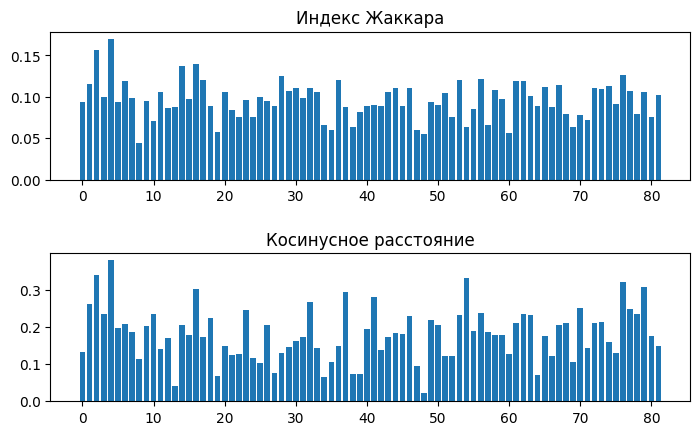

In [11]:
show_statistics_and_bar(jaccard_sim,cos_sim)

#### Изображаем доверительный интервал для метрик.

  0%|          | 0/1000 [00:00<?, ?it/s]

/home/mixailkys/PycharmProjects/grammar_ru/tg/common/ml/miscellaneous/kraken.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(pd_result)
/home/mixailkys/PycharmProjects/grammar_ru/tg/common/ml/miscellaneous/kraken.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(pd_result)
/home/mixailkys/PycharmProjects/grammar_ru/tg/common/ml/miscellaneous/kraken.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(pd_result)
/home/mixailkys/PycharmProjects/grammar_ru/tg/common/ml/miscellaneous/kraken.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.ap

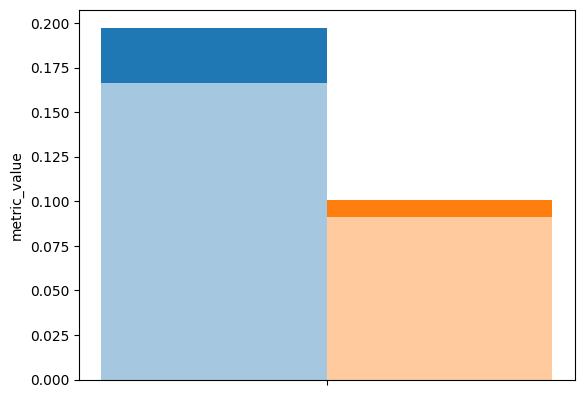

In [12]:
plot_confint(jaccard_sim,cos_sim)